## Surname Classification

## DMiA 2018 (spring) #Спорт

**Домашнее задание 1**

Выполнил: Головенков Евгений

14 место (0.93278 Private Leaderboard)


**Решение**

1. Убрать повторяющиеся слова из train, причем с игнорированием регистра букв, например, убираем и "ААРОН", и "Аарон".
2. Сгенерировать много признаков: 

    1) простых статистических (кол-во букв, доля гласных и т.д.); 
    
    2) использовать анализаторы Natasha, pymorphy2, pymystem3; 
    
    3) получить все n-gram из 2х и 3х букв; 
    
    4) отдельно взять категориальный признак - последние 3 буквы
    
3. Закодировать признаки: CountVectorizer, LabelEncoder, BinaryEncoder (последний больше всего понравился: долго строится, но очень-очень экономит место по сравнению со стандартным one-hot)
4. Обучить XGBoost
5. Дотюнить XGBoost (только начало)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_valid = pd.read_csv('test.csv')

In [5]:
df_train.head()

,Word,Label
0,Аалтонен,1
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0


In [6]:
print(df_train['Label'].value_counts())
print(df_train['Label'].value_counts()[0]/df_train.shape[0])
print(df_train['Label'].value_counts()[1]/df_train.shape[0])

0    90770
1    10638
Name: Label, dtype: int64
0.8950970337645945
0.10490296623540549


## Cleaning data


In [7]:
# for i in df_train.values:print(i)

In [8]:
# for i in df_valid.values:print(i)

In [9]:
len(df_train[df_train['Word'] == 'Аалтонен'])
df_train[df_train['Word'] == 'ИНГ']['Label'].iloc[:,]

29223    0
29224    1
Name: Label, dtype: int64

In [10]:
# Видим, что присутствуют строки с повторяющимся словом и разным таргетом
# Найдем их

df_tmp_1 = pd.DataFrame(df_train['Word']).groupby(by='Word').size().reset_index().rename(columns={0: 'Count'})
dup_words_1 = list(df_tmp_1[df_tmp_1.Count > 1]['Word'])
duplicates_1 = df_train[df_train['Word'].apply(lambda row: row in dup_words_1)].index

In [11]:
duplicates_1_list_indices = list(duplicates_1)
duplicates_1_list_indices[:5]

[4, 5, 42, 43, 474]

In [12]:
print("Строк с повторяющимися словами (1): {}".format(len(duplicates_1_list_indices)))
df_train.iloc[duplicates_1_list_indices].head(n=10)

Строк с повторяющимися словами (1): 1450


,Word,Label
4,Аарона,0
5,Аарона,1
42,аббревиатура,0
43,аббревиатура,1
474,автоматизация,0
475,автоматизация,1
793,Адамов,0
794,Адамов,1
807,адаптация,0
809,адаптация,1


In [13]:
# Также видим, что присутствуют строки с повторяющимися словами, но с разным регистром букв, у которых разный таргет
# Найдем их

df_tmp_2 = pd.DataFrame(df_train['Word'].apply(lambda word: word.lower())).groupby(by='Word').size().reset_index().rename(columns={0: 'Count'})
dup_words_2 = list(df_tmp_2[df_tmp_2.Count > 1]['Word'])
duplicates_2 = df_train[df_train['Word'].apply(lambda row: row.lower() in dup_words_2)].index

In [14]:
duplicates_2_list_indices = list(duplicates_2)
print(duplicates_2_list_indices[:5])
print("Повторяющихся строк (2): {}".format(len(duplicates_2_list_indices)))
df_train.iloc[duplicates_2_list_indices].head()

[2, 3, 4, 5, 12]
Повторяющихся строк (2): 24462


,Word,Label
2,Аарон,0
3,ААРОН,0
4,Аарона,0
5,Аарона,1
12,абажуры,0


In [15]:
# Найдем слова с символами, отличными от кириллицы
# 1. Удалим те из них, которые несмотря ни на что помечены как фамилии - если такие есть
# 2. Содержание некириллических символов (кроме дефиза) - далее будет использоваться в качестве бинарного признака

NOT_CYRILLIC = '[^ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁйцукенгшщзхъфывапролджэячсмитьбюё]'
NOT_CYRILLIC_AND_HYPHEN = "[^ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁйцукенгшщзхъфывапролджэячсмитьбюё'’-]"

import re
column_containes_not_allowed_symbols = df_train['Word'] \
        .apply(lambda x: True if len(re.findall(NOT_CYRILLIC_AND_HYPHEN, x, re.IGNORECASE)) > 0 else False)

not_allowed_indices = (df_train[column_containes_not_allowed_symbols]).index


print(df_train[(column_containes_not_allowed_symbols)]['Label'].sum())
df_train[column_containes_not_allowed_symbols].head()

1


,Word,Label
9887,в.,0
9888,В.,0
9889,В·А,0
9890,вóронами,0
14958,г.,0


In [16]:
# Найдем те слова, которые есть и в тесте, и в обучении

intersecting_words = list(df_train.set_index('Word').join(df_valid.set_index('Word'), rsuffix='v_', how='inner').reset_index()['Word'])
df_train[df_train['Word'].apply(lambda row: row in intersecting_words)].head(n=10)

,Word,Label
2,Аарон,0
6,Аароне,0
7,Ааронов,0
48,Абдул,0
130,Абрамовича,0
254,аварии,0
269,Август,0
270,АВГУСТ,1
272,Августин,1
274,Августину,1


In [17]:
# Запомним их для корректировки df_valid
df_intersected = df_train[df_train['Word'].apply(lambda row: row in intersecting_words)]
df_intersected.shape

(2785, 2)

### Baseline

Выкидываем неправильные данные

In [18]:
df_train_uncutted = df_train.copy()
df_train.drop(duplicates_2_list_indices, axis=0, inplace=True)

Нужно создать признаки

In [19]:
# 1a. Общее количество символов

df_train['All_Count'] = df_train['Word'].apply(lambda w: len(w))
df_valid['All_Count'] = df_valid['Word'].apply(lambda w: len(w))

# 1b. Количество символов > 3 ?
df_train['All_C_gt3'] = df_train['All_Count'].apply(lambda w: 1 if w > 3 else 0)
df_valid['All_C_gt3'] = df_valid['All_Count'].apply(lambda w: 1 if w > 3 else 0)

# 2. Первая буква - заглавная, остальные строчные
df_train['Capitalize'] = df_train['Word'].apply(lambda w: 1 if (w[0].isupper() and w[1:].islower()) else 0)
df_valid['Capitalize'] = df_valid['Word'].apply(lambda w: 1 if (w[0].isupper() and w[1:].islower()) else 0)

# 3. Все буквы - заглавные
df_train['All_Upper'] = df_train['Word'].apply(lambda w: 1 if w.isupper() else 0)
df_valid['All_Upper'] = df_valid['Word'].apply(lambda w: 1 if w.isupper() else 0)

# 4. Все буквы - строчные
df_train['All_Lower'] = df_train['Word'].apply(lambda w: 1 if w.islower() else 0)
df_valid['All_Lower'] = df_valid['Word'].apply(lambda w: 1 if w.islower() else 0)

# 5a. Есть как строчные, так и заглавные, в разных порядках
df_train['Mixed_Registry'] = df_train['Word'] \
        .apply(lambda w: 1 if (not(w[0].isupper() and w[1:].islower()) and not w.isupper() and not w.islower()) else 0)
df_valid['Mixed_Registry'] = df_valid['Word'] \
        .apply(lambda w: 1 if (not(w[0].isupper() and w[1:].islower()) and not w.isupper() and not w.islower()) else 0)
    
# 5b. Слово начинается с О' и затем следует заглавная киррилическая буква
RE_STARTS_W_O = r"^О['’][ЙЦУКЕНГШЩЗХФВАПРОЛДЖЭЯЧСМИТБЮЁ]"
df_train['Starts_w_O'] = df_train['Word'].apply(lambda w: 1 if len(re.findall(RE_STARTS_W_O, w)) > 0 else 0)
df_valid['Starts_w_O'] = df_valid['Word'].apply(lambda w: 1 if len(re.findall(RE_STARTS_W_O, w)) > 0 else 0)

# 5c. В середине слова есть последовательность: дефиз и затем заглавная буква
RE_HYPHEN_IN_THE_MIDDLE = r"-[ЙЦУКЕНГШЩЗХФВАПРОЛДЖЭЯЧСМИТБЮЁ]"
df_train['Middle_Hyphen'] = df_train['Word'].apply(lambda w: 1 if len(re.findall(RE_HYPHEN_IN_THE_MIDDLE, w)) > 0 else 0)
df_valid['Middle_Hyphen'] = df_valid['Word'].apply(lambda w: 1 if len(re.findall(RE_HYPHEN_IN_THE_MIDDLE, w)) > 0 else 0)

# 5d. Слово начинается с Мак
RE_STARTS_W_MAC = r"Мак"
df_train['Starts_w_Mac'] = df_train['Word'].apply(lambda w: 1 if len(re.findall(RE_STARTS_W_MAC, w)) > 0 else 0)
df_valid['Starts_w_Mac'] = df_valid['Word'].apply(lambda w: 1 if len(re.findall(RE_STARTS_W_MAC, w)) > 0 else 0)

# 5e. Число дефизов
df_train['Hypen_Counts'] = df_train['Word'].apply(lambda w: len(re.findall(r'-', w)))
df_valid['Hypen_Counts'] = df_valid['Word'].apply(lambda w: len(re.findall(r'-', w)))

# 5ea. Число апостофов
df_train['Apostr_Counts'] = df_train['Word'].apply(lambda w: len(re.findall(r"['’]", w)))
df_valid['Apostr_Counts'] = df_valid['Word'].apply(lambda w: len(re.findall(r"['’]", w)))

# 5f. Число пробелов
df_train['Space_Counts'] = df_train['Word'].apply(lambda w: len(re.findall(r' ', w)))
df_valid['Space_Counts'] = df_valid['Word'].apply(lambda w: len(re.findall(r' ', w)))

# 5g. Количество заглавых букв
RE_CAPS = u'[ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁ]'
df_train['Caps_Count'] = df_train['Word'].apply(lambda w: len(re.findall(RE_CAPS, w)))
df_valid['Caps_Count'] = df_valid['Word'].apply(lambda w: len(re.findall(RE_CAPS, w)))

# 5h. Доля заглавных букв в слове (хорошо для аббревиатур)
df_train['Caps_Ratio'] = df_train['Caps_Count'] / df_train['All_Count']
df_valid['Caps_Ratio'] = df_valid['Caps_Count'] / df_valid['All_Count']

# 5i. Содержат некириллические символов (кроме дефиза и апострофов)
NOT_CYRILLIC_AND_HYPHEN = "[^ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁйцукенгшщзхъфывапролджэячсмитьбюё'’-]"
df_train['Have_Restr_Chars'] = df_train['Word'].apply(lambda w: 1 if len(re.findall(NOT_CYRILLIC_AND_HYPHEN, w)) > 0 else 0)
df_valid['Have_Restr_Chars'] = df_valid['Word'].apply(lambda w: 1 if len(re.findall(NOT_CYRILLIC_AND_HYPHEN, w)) > 0 else 0)

# 5j. Содержат только кириллицу (без дефиза и апострофов)
NOT_CYRILLIC = '[^ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁйцукенгшщзхъфывапролджэячсмитьбюё]'
df_train['Cyrillic_Only'] = df_train['Word'].apply(lambda w: 0 if len(re.findall(NOT_CYRILLIC, w)) > 0 else 1)
df_valid['Cyrillic_Only'] = df_valid['Word'].apply(lambda w: 0 if len(re.findall(NOT_CYRILLIC, w)) > 0 else 1)

# 6a. Число гласных
df_train['Vow_Count'] = df_train['Word'].apply(lambda w: len(re.findall('[уеыаоэяиюё]', w, re.I)))
df_valid['Vow_Count'] = df_valid['Word'].apply(lambda w: len(re.findall('[уеыаоэяиюё]', w, re.I)))

# 6b. Доля гласных
df_train['Vow_Ratio'] = df_train['Vow_Count'] / df_train['All_Count']
df_valid['Vow_Ratio'] = df_valid['Vow_Count'] / df_valid['All_Count']

# 7a. Число согласных
df_train['Conson_Count'] = df_train['Word'].apply(lambda w: len(re.findall('[йцкнгшщзхфвпрлджчсмтб]', w, re.I)))
df_valid['Conson_Count'] = df_valid['Word'].apply(lambda w: len(re.findall('[йцкнгшщзхфвпрлджчсмтб]', w, re.I)))

# 7b. Доля согласных
df_train['Conson_Ratio'] = df_train['Conson_Count'] / df_train['All_Count']
df_valid['Conson_Ratio'] = df_valid['Conson_Count'] / df_valid['All_Count']

In [20]:
# 8a, b. Проверить на фамилию и одушевленность с помощью pymorphy
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def is_surname(w):
    for p in morph.parse(w):
        tags = str(p.normalized.tag).split(',')
        for tag in tags:
            if 'Surn' in tag.split(' '):
                return 1
    return 0

def is_anim(w):
    for p in morph.parse(w):
        tags = str(p.normalized.tag).split(',')
        if 'anim' in tags:
            return 1
    return 0

df_train['pm_surn'] = df_train['Word'].apply(is_surname)
df_valid['pm_surn'] = df_valid['Word'].apply(is_surname)


df_train['pm_anim'] = df_train['Word'].apply(is_anim)
df_valid['pm_anim'] = df_valid['Word'].apply(is_anim)


df_train['pm'] = df_train['Word'].apply(lambda x: morph.tag(x)[0])
df_valid['pm'] = df_valid['Word'].apply(lambda x: morph.tag(x)[0])

df_train['pm_animacy'] = df_train['pm'].apply(lambda x: x.animacy)
df_valid['pm_animacy'] = df_valid['pm'].apply(lambda x: x.animacy)
df_train['pm_POS'] = df_train['pm'].apply(lambda x: x.POS)
df_valid['pm_POS'] = df_valid['pm'].apply(lambda x: x.POS)
df_train['pm_case'] = df_train['pm'].apply(lambda x: x.case)
df_valid['pm_case'] = df_valid['pm'].apply(lambda x: x.case)
df_train['pm_number'] = df_train['pm'].apply(lambda x: x.number)
df_valid['pm_number'] = df_valid['pm'].apply(lambda x: x.number)
df_train['pm_gender'] = df_train['pm'].apply(lambda x: x.gender)
df_valid['pm_gender'] = df_valid['pm'].apply(lambda x: x.gender)

df_train.drop('pm' , axis=1 , inplace=True)
df_valid.drop('pm' , axis=1 , inplace=True)

columns_to_one_hot = ['pm_animacy', 'pm_POS', 'pm_case','pm_number', 'pm_gender']

In [21]:
from sklearn.preprocessing import LabelEncoder
for col in columns_to_one_hot:
    lab_enc = LabelEncoder().fit(list(pd.concat([df_train[col], df_valid[col]]).apply(lambda r: 'nan' if r is None else r)))
    df_train[col] = lab_enc.transform(list(df_train[col].apply(lambda r: 'nan' if r is None else r)))
    df_valid[col] = lab_enc.transform(list(df_valid[col].apply(lambda r: 'nan' if r is None else r)))

In [22]:
# 9. Natasha нашла совпадение по исходному слову ?
from natasha import NamesExtractor
extractor = NamesExtractor()

def get_natasha(w):
    matches = extractor(w)
    if matches:
        if matches[0].fact.last:
            return matches[0].fact.last
        else:
            return ""
    else:
        return ""

In [23]:
df_train['natasha_raw'] = df_train['Word'].apply(get_natasha)
df_valid['natasha_raw'] = df_valid['Word'].apply(get_natasha)

In [24]:
# 11a. Natasha нашла совпадение по сырым данным ?
df_train['natasha_found_raw'] = df_train['natasha_raw'].apply(lambda w: 1 if len(w) > 0 else 0)
df_valid['natasha_found_raw'] = df_valid['natasha_raw'].apply(lambda w: 1 if len(w) > 0 else 0)

In [25]:
# 12. n-grams
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='char', ngram_range=(2,3), min_df = 0)

corpus = pd.concat([df_train['Word'], df_valid['Word']])
vect = cv.fit(corpus)
vect

CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(2, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
vect_cols_train = vect.transform(df_train['Word'])
vect_cols_valid = vect.transform(df_valid['Word'])

vect_cols_train.shape

(76946, 12770)

In [27]:
# 13. 3 последних буквы без учета регистра (или меньше, если слово короткое)
df_train['Last3'] = df_train['Word'].apply(lambda w: w[-3:])
df_valid['Last3'] = df_valid['Word'].apply(lambda w: w[-3:])

In [29]:
# Кодируем 'Last3'
# df_train.Last3.value_counts().head()

from category_encoders import *
enc = BinaryEncoder().fit(pd.concat([df_train['Last3'], df_valid['Last3']]).to_frame())
last3_train_cols = enc.transform(df_train['Last3'].to_frame())
last3_valid_cols = enc.transform(df_valid['Last3'].to_frame())

last3_train_cols.columns, last3_valid_cols.columns

(Index(['Last3_0', 'Last3_1', 'Last3_2', 'Last3_3', 'Last3_4', 'Last3_5',
        'Last3_6', 'Last3_7', 'Last3_8', 'Last3_9', 'Last3_10', 'Last3_11',
        'Last3_12', 'Last3_13'],
       dtype='object'),
 Index(['Last3_0', 'Last3_1', 'Last3_2', 'Last3_3', 'Last3_4', 'Last3_5',
        'Last3_6', 'Last3_7', 'Last3_8', 'Last3_9', 'Last3_10', 'Last3_11',
        'Last3_12', 'Last3_13'],
       dtype='object'))

In [30]:
# 14. pymystem3

import pymystem3
mystem = pymystem3.Mystem()

def name_from_pymystem(word):
    try:
        return 1 if 'имя' in mystem.analyze(word)[0]['analysis'][0]['gr'].split(',') else 0
    except:
        return 0

def surn_from_pymystem(word):
    try:
        return 1 if 'фам' in mystem.analyze(word)[0]['analysis'][0]['gr'].split(',') else 0
    except:
        return 0

df_train['name_from_pymystem'] = df_train['Word'].apply(name_from_pymystem)
df_valid['name_from_pymystem'] = df_valid['Word'].apply(name_from_pymystem)

df_train['surn_from_pymystem'] = df_train['Word'].apply(surn_from_pymystem)
df_valid['surn_from_pymystem'] = df_valid['Word'].apply(surn_from_pymystem)

In [33]:
# Склеиваем признаки

import scipy
df4_train = scipy.sparse.hstack(
    (df_train.drop(labels=['Label', 'Word', 'natasha_raw', 'Last3'], axis=1).to_sparse(), 
     last3_train_cols.to_sparse(),
     vect_cols_train
    ))
df4_valid = scipy.sparse.hstack(
    (df_valid.drop(labels=['Word', 'natasha_raw', 'Last3'], axis=1).to_sparse(), 
     last3_valid_cols.to_sparse(),
     vect_cols_valid
    ))

In [34]:
df4_train.shape

(76946, 12814)

In [ ]:
# df_train[(df_train.Mixed_Registry == 1) & (df_train.Label == 1)]
# df_valid[(df_valid.Mixed_Registry == 1)]

In [35]:
def make_submission(X, y):
    submission = pd.DataFrame({'Id': range(0, X.shape[0]), 'Prediction': y})
    submission.to_csv('baseline.csv', index=False)

## Saving data

In [41]:
df_train.to_csv("df_train.csv")
df_valid.to_csv("df_valid.csv")

In [42]:
last3_train_cols.to_csv("last3_train_cols.csv")
last3_valid_cols.to_csv("last3_valid_cols.csv")

In [43]:
scipy.sparse.save_npz("vect_cols_train.npz", vect_cols_train)
scipy.sparse.save_npz("vect_cols_valid.npz", vect_cols_valid)

In [40]:
scipy.sparse.save_npz("df4_train.npz", df4_train)
scipy.sparse.save_npz("df4_valid.npz", df4_valid)

## Train

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [37]:
baseline_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, verbose=True)

In [38]:
cr_val_sc1 = cross_val_score(baseline_clf, 
                             df4_train, 
                             df_train['Label'], scoring='roc_auc', cv=3, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.9s finished


In [39]:
baseline_score = np.mean(cr_val_sc1)
print(cr_val_sc1)
print(baseline_score)

[0.9532292  0.9446874  0.94124469]
0.9463870969704824


## Test

In [ ]:
# baseline_clf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1, verbose=True)
# baseline_clf.fit(df4_train, 
#                  df_train['Label'])

In [ ]:
# y_pred = baseline_clf.predict_proba(df4_valid)

In [ ]:
# df3 = df_valid.copy()
# df3['Label'] = y_pred[:, 1]
# df3[5400:5420]

In [ ]:
# make_submission(df_valid, y_pred[:, 1])

**XGBoost**

In [44]:
train_full = df4_train
test_full = df4_valid

In [96]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import gc

print('Binding to float32')

x_train, x_valid, y_train, y_valid = train_test_split(train_full, df_train['Label'], random_state=17)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)


del x_train, x_valid; gc.collect()   
                   
print('Training ...')

params = {'max_depth': 5, 
          'min_child_weight': 3, 
#           'subsample': 0.9,
#           'colsample_bytree': 0.7,  
#           'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.3, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 17
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(train_full, label=df_train['Label'])
print('AUC XgBoost: ', roc_auc_score(df_train['Label'], model1.predict(d_train_full)))

Binding to float32
Building DMatrix...
Training ...
[0]	train-auc:0.93467	valid-auc:0.932582
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.956948	valid-auc:0.953274
[20]	train-auc:0.963489	valid-auc:0.957466
[30]	train-auc:0.966115	valid-auc:0.958588
[40]	train-auc:0.967783	valid-auc:0.95982
[50]	train-auc:0.969133	valid-auc:0.960335
[60]	train-auc:0.970191	valid-auc:0.960532
[70]	train-auc:0.971165	valid-auc:0.960678
[80]	train-auc:0.972115	valid-auc:0.961155
[90]	train-auc:0.972868	valid-auc:0.96123
[100]	train-auc:0.973615	valid-auc:0.9616
[110]	train-auc:0.974595	valid-auc:0.961643
[120]	train-auc:0.975208	valid-auc:0.961781
[130]	train-auc:0.97565	valid-auc:0.961831
[140]	train-auc:0.976127	valid-auc:0.961818
[150]	train-auc:0.976836	valid-auc:0.961886
[160]	train-auc:0.977546	valid-auc:0.961986
[170]	train-auc:0.97795	valid-auc:0.961992
[180]	train-auc:0.978444	valid

0.9679495397146379

0.9704433217130342

0.9730505703627768

0.9808807939779546

0.9873862602344029  9 3

0.9847116793051924  5 3 - но лучше на leaderboard

In [97]:
x_test = test_full.copy()
d_test = xgb.DMatrix(x_test)
train_full.shape, test_full.shape

((76946, 12814), (188920, 12814))

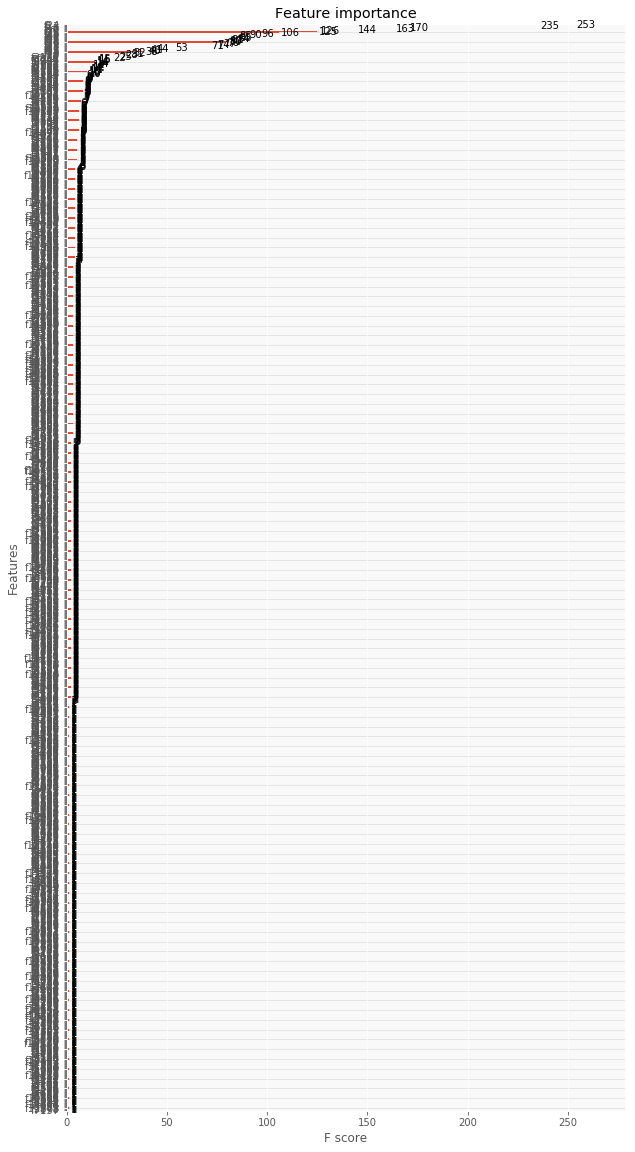

In [90]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
%matplotlib inline
my_plot_importance(model1, (10,20))

## Tuning XGBoost

Эту часть выполнить как задумывалось - не удалось. В итоге подобрал только `max_depth` и `min_child_weight`. Здесь остается определенный потенциал в ускорении.

In [82]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

def modelfit(alg, dtrain, y, useTrainCV=True, cv_folds=3, early_stopping_rounds=100):
    
#     x_train, x_valid, y_train, y_valid = train_test_split(train_full, df_train['Label'], random_state=17)

# print('Building DMatrix...')
# d_train = xgb.DMatrix(x_train, label=y_train)
# d_valid = xgb.DMatrix(x_valid, label=y_valid)


# del x_train, x_valid; gc.collect()   
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

/home/evgeny/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9451
AUC Score (Train): 0.960487


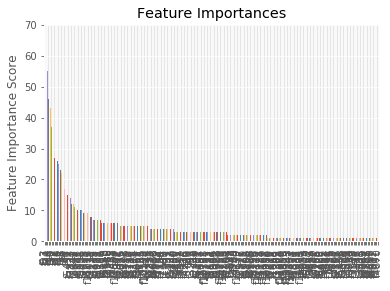

In [78]:
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective= 'binary:logistic',
        n_jobs=-1,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, df4_train, df_train['Label'])

In [80]:
param_test1 = {
    'max_depth':range(3,12,2),
    'min_child_weight':range(1,13,2)
}

In [83]:
gsearch1 = GridSearchCV(
    XGBClassifier(learning_rate=0.1, 
                  n_estimators=150,
                  objective= 'binary:logistic', 
                  scale_pos_weight=1, 
                  seed=27), 
    param_grid = param_test1, scoring='roc_auc', iid=False, cv=3, n_jobs=-1, verbose=True
)

In [85]:
gsearch1.fit(df4_train,df_train['Label'])

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': range(3, 12, 2), 'min_child_weight': range(1, 13, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [86]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/evgeny/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.94893, std: 0.00648, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.94925, std: 0.00599, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.94982, std: 0.00602, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.94978, std: 0.00658, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.94994, std: 0.00625, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.94960, std: 0.00664, params: {'max_depth': 3, 'min_child_weight': 11},
  mean: 0.95220, std: 0.00506, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.95270, std: 0.00488, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.95264, std: 0.00504, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.95288, std: 0.00507, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.95282, std: 0.00489, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: 0.95272, std: 0.00505, params: {'max_depth': 5, 'min_child_weight': 11},
  mean: 0.95297, std: 0.00398, params:

{'max_depth': 9, 'min_child_weight': 3} - это submission # 6

Тем не менее лучшие результаты (submission # 7) на лидерборде показал XGBoost на параметрах

```
params = {'max_depth': 5, 
          'min_child_weight': 3, 
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.3, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 17
         }
```

## Submission

In [98]:
sub = pd.read_csv('sample_submission.csv')
sub = sub.reset_index(drop=True)

In [99]:
sub['Prediction'] = model1.predict(d_test)
sub.head()

,Id,Prediction
0,0,0.468586
1,1,0.345176
2,2,0.406583
3,3,0.132574
4,4,0.346994


In [100]:
sub.to_csv('submission_xgb_7.csv', columns=['Id', 'Prediction'], index=False)

## Control predictions on intersected words

In [101]:
intersecting_words[:4]

['АВГУСТ', 'АРЕН', 'Аарон', 'Аароне']

In [102]:
df_intersected.head(5)

,Word,Label
2,Аарон,0
6,Аароне,0
7,Ааронов,0
48,Абдул,0
130,Абрамовича,0


In [103]:
df_same = df_train[df_train['Word'].apply(lambda row: row in intersecting_words)][['Word', 'Label']]
df_same.head(5)

,Word,Label
6,Аароне,0
7,Ааронов,0
48,Абдул,0
130,Абрамовича,0
254,аварии,0


In [104]:
df_valid['Prediction'] = sub['Prediction']

In [ ]:
# df_train[df_train.apply(lambda row: True if row.Word =='Эли' else False, axis=1)]['Label']

In [105]:
# df_valid[['Word', 'Prediction', 'Real_P']].iloc[df_same.index]
df_same_2 = df_valid[df_valid['Word'].apply(lambda row: row in intersecting_words)][['Word', 'Prediction']]
# df_same_2['Label'] = df_same_2.apply(lambda r: df_train[df_train.apply(lambda row: True if row.Word == r.Word else False, axis=1)]['Label'] if r.Word in intersecting_words else -999, axis=1)

df_same_2.head(5)

,Word,Prediction
4,Аарон,0.346994
5,Аароне,0.748925
6,Ааронов,0.588364
105,Абдул,0.057268
268,Абрамовича,0.722980


In [106]:
df_same_3 = df_same_2.set_index('Word').join(df_same.set_index('Word'), rsuffix='_valid', how='right').reset_index()
list(df_same_3.values)

[array(['Аароне', 0.7489250898361206, 0], dtype=object),
 array(['Ааронов', 0.5883635878562927, 0], dtype=object),
 array(['Абдул', 0.0572676844894886, 0], dtype=object),
 array(['Абрамовича', 0.7229800820350647, 0], dtype=object),
 array(['аварии', 0.0010772556997835636, 0], dtype=object),
 array(['Августин', 0.25324493646621704, 1], dtype=object),
 array(['Августом', 0.042023640125989914, 1], dtype=object),
 array(['австралиец', 0.011567550711333752, 0], dtype=object),
 array(['автокаско', 0.1331986039876938, 1], dtype=object),
 array(['автоматов', 0.03912557289004326, 1], dtype=object),
 array(['автор', 0.012746892869472504, 0], dtype=object),
 array(['агент', 0.06289348751306534, 1], dtype=object),
 array(['агентство', 0.09566739201545715, 1], dtype=object),
 array(['агрегирования', 0.022660890594124794, 1], dtype=object),
 array(['ад', 0.040388450026512146, 0], dtype=object),
 array(['адвокаты', 0.006046120543032885, 0], dtype=object),
 array(['Адмиралтейство', 0.00036624007043428

In [107]:
# Да, в тестовом множестве записей будет больше за счет того, что мы удалили некоторые строки из обучающего множества
print(len(df_train[['Word', 'Label']][df_train['Word'] == 'Аарон']))
print('Аарон' in intersecting_words)
print('Аарон'.lower() in dup_words_2)

0
True
True


Классификатор выглядит неплохо, даже на тех значениях в тестовой выборке, например,

    array(['Азизов', 0], dtype=object)
    array(['Николаеве', 0], dtype=object),
    array(['агент', 1], dtype=object)
    array(['подражания', 1], dtype=object),
    array(['подстановка', 1], dtype=object),
    
где изначально (в обучающей выборке) метка ставилась неверно.
